In [5]:
from datasets import load_dataset
import pandas as pd

In [45]:
scores = load_dataset("nuprl/pass_k_with_MultiPL-E", split="train", use_auth_token=True, revision="bigcode_scaling_laws")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1162 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/leandro/.cache/huggingface/datasets/nuprl___parquet/nuprl--pass_k_with_MultiPL-E-7d0175e94ceed6c3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [46]:
max(scores["PassRate"])

0.5071184859461587

In [47]:
scores[0]

{'Experiment': 'humaneval-java-bigcode_scalinglaws_run_1514.4M_3e+19_bs8_idx_51-0.8-reworded',
 'k': 10,
 'PassRate': 0.0275730360024084}

In [48]:
scores = scores.map(lambda x: {"idx": int(x["Experiment"].split("idx_")[1].split("-")[0])})
scores = scores.map(lambda x: {"lang": x["Experiment"].split("humaneval-")[1].split("-")[0]})

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

In [50]:
scores = scores.filter(lambda x: x["k"]==100)
scores = scores.filter(lambda x: x["lang"]=="java")

Filter:   0%|          | 0/1162 [00:00<?, ? examples/s]

Filter:   0%|          | 0/581 [00:00<?, ? examples/s]

In [51]:
df_scores = scores.to_pandas()

In [53]:
df_experiments = pd.read_csv("scaling_laws.csv")

In [54]:
df = df_scores.merge(df_experiments, how="left", on="idx")

In [55]:
df.sort_values(by="PassRate", ascending=False)

,Experiment,k,PassRate,idx,lang,num_layer,hidden_size,num_heads,param_count,compute,training_tokens,attention_head_type,sequence_length,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters
84,humaneval-java-bigcode_scalinglaws_run_3026.4M...,100,0.507118,113,java,36,2816,22,3026.4,1.000000e+21,5.510000e+10,multiquery,2048,524000.0,256,0.00015,32,2.898,8,105040,1000
54,humaneval-java-bigcode_scalinglaws_run_3026.4M...,100,0.442785,104,java,36,2816,22,3026.4,6.000000e+20,3.300000e+10,multiquery,2048,524000.0,256,0.00015,32,1.739,8,63024,1000
80,humaneval-java-bigcode_scalinglaws_run_3026.4M...,100,0.360712,94,java,36,2816,22,3026.4,3.000000e+20,1.650000e+10,multiquery,2048,524000.0,256,0.00015,16,1.739,16,31512,1000
89,humaneval-java-bigcode_scalinglaws_run_2118.0M...,100,0.306464,112,java,30,2560,20,2118.0,1.000000e+21,7.870000e+10,multiquery,2048,524000.0,256,0.00015,32,2.898,8,150090,1000
16,humaneval-java-bigcode_scalinglaws_run_1514.4M...,100,0.295883,111,java,26,2304,18,1514.4,1.000000e+21,1.100000e+11,multiquery,2048,524000.0,256,0.00015,32,2.898,8,209905,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,humaneval-java-bigcode_scalinglaws_run_28.9M_1...,100,0.000000,27,java,6,384,6,28.9,1.000000e+19,5.770000e+10,multiquery,2048,524000.0,256,0.00030,2,0.464,128,110079,1000
22,humaneval-java-bigcode_scalinglaws_run_11.4M_6...,100,0.000000,12,java,4,192,3,11.4,6.000000e+18,8.740000e+10,multiquery,2048,524000.0,256,0.00030,2,0.278,128,166772,1000
43,humaneval-java-bigcode_scalinglaws_run_28.9M_3...,100,0.000000,3,java,6,384,6,28.9,3.000000e+18,1.730000e+10,multiquery,2048,524000.0,256,0.00030,2,0.139,128,33023,1000
71,humaneval-java-bigcode_scalinglaws_run_15.9M_1...,100,0.000000,26,java,4,256,4,15.9,1.000000e+19,1.050000e+11,multiquery,2048,524000.0,256,0.00030,2,0.464,128,199878,1000


In [79]:
df = df[df["PassRate"]>0.0]

In [98]:
from scipy.special import logsumexp
from scipy.special import huber
import numpy as np


def function(x):
    a, b, e, alpha, beta = x
    overall_sum = 0
    for N, D, L in zip(df["training_tokens"], df["param_count"], df["PassRate"]):
        element = huber(0.001, logsumexp([a - alpha*np.log(N),b -  beta*np.log(D), e]) - np.log(L))
        overall_sum+=element
    return overall_sum

In [103]:
min_value = 1e10

from tqdm import tqdm

for a in tqdm(np.linspace(-100, 0, 6)):
    for b in np.linspace(-20, 20, 6):
        for e in np.linspace(-10, 10, 5):
            for alpha in np.linspace(-4, 0,5):
                for beta in np.linspace(-1,2,5):
                    value = function((a, b, e, alpha, beta))
                    if value<min_value:
                        best_config = (a, b, e, alpha, beta)
                        min_value = value
best_config

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]


(-60.0, -4.0, -10.0, -2.0, -0.25)

In [112]:
from scipy.optimize import minimize

params = minimize(function, best_config, method="L-BFGS-B")
params

      fun: 0.0394893431079757
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.66616707e-05,  3.42573194e-06,  1.21708189e-06, -4.21185309e-04,
       -1.56388790e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 864
      nit: 67
     njev: 144
   status: 0
  success: True
        x: array([-14.55415162,  -7.57197121, -11.08439789,  -0.4835721 ,
        -0.69790846])

In [113]:
def scaling_law(N, D, params):
    a, b, e, alpha, beta = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    
    L =  E + (A / (N**alpha)) + (B /(D**beta))
    
    return L

In [129]:
scaling_law(1e12, 15_000, params.x)

0.7261895955849371

# Inverse

In [197]:
def function(x):
    a, b, e, alpha, beta = x
    overall_sum = 0
    for N, D, L in zip(df["training_tokens"], df["param_count"], df["PassRate"]):
        L = 1/L
        element = huber(0.001, logsumexp([a - alpha*np.log(N),b -  beta*np.log(D), e]) - np.log(L))
        overall_sum+=element
    return overall_sum

In [198]:
min_value = 1e10

from tqdm import tqdm

for a in tqdm(np.linspace(0, 25, 6)):
    for b in np.linspace(0, 25, 6):
        for e in np.linspace(-1, 1, 5):
            for alpha in np.linspace(0, 2,5):
                for beta in np.linspace(0,2,5):
                    value = function((a, b, e, alpha, beta))
                    if value<min_value:
                        best_config = (a, b, e, alpha, beta)
                        min_value = value
best_config

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.46s/it]


(25.0, 10.0, 1.0, 1.0, 1.5)

In [229]:
params = minimize(function, best_config, method="L-BFGS-B")
params

      fun: 0.01486835219677188
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.29378858e-05,  1.96582335e-05, -2.94105018e-06, -6.82832953e-04,
       -7.29050505e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1230
      nit: 113
     njev: 205
   status: 0
  success: True
        x: array([15.85478558,  7.13224508, -0.33702823,  0.59841397,  1.00090823])

In [224]:
def scaling_law(N, D, params):
    a, b, e, alpha, beta = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    L =  E + (A / (N**alpha)) + (B /(D**beta))
    
    return 1/L

In [237]:
scaling_law(1e12, 10_000, params.x)

0.7436992351007352

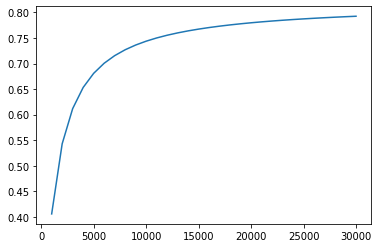

In [238]:
import matplotlib.pyplot as plt

x = np.linspace(1_000, 30_000, 30)

plt.plot(x, [scaling_law(1e12, i, params.x) for i in x])

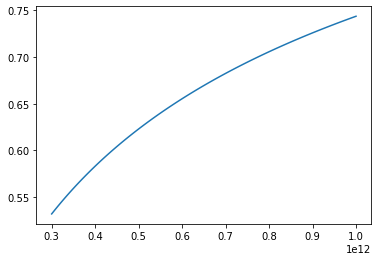

In [245]:
x = np.linspace(3e11, 1e12, 100)

plt.plot(x, [scaling_law(i, 10_000, params.x) for i in x])